In [76]:
mask_dir = r'E:\Ultimate\day1_streams\masks'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import cv2

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [77]:
test_image_path = 'E:/Ultimate/day1_streams/masks/102_58.1.png'
image_mask_dir = 'E:/Ultimate/day1_streams/masks'

In [78]:
def test_and_plot_image(test_image_path):
    img_rgb = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    img_inrange = cv2.inRange(img, (0, 0, 0), (180, 255, 80))
    img_inverted = cv2.bitwise_not(img_inrange)
    
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(img_rgb)
    ax[1].imshow(img_inverted)
    
    return img_inverted

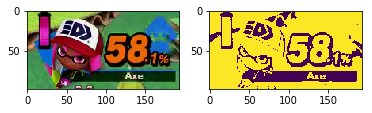

In [79]:
# TODO: Measure perf
img_inverted = test_and_plot_image(test_image_path)

In [80]:
print(img_inverted)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [115]:
def extract_blobs(binary_image):
    connectivity = 8
    output = cv2.connectedComponentsWithStats(binary_image, connectivity, cv2.CV_8S)
    
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    blobs = []
    for label in range(num_labels):
        stats_indices = [cv2.CC_STAT_LEFT, cv2.CC_STAT_WIDTH, cv2.CC_STAT_TOP, cv2.CC_STAT_HEIGHT]
        xmin, width, ymin, height = [stats[label][i] for i in stats_indices]
        
        xmax = xmin + width
        ymax = ymin + height

        blob = np.where(labels[ymin:ymax, xmin:xmax] == label, 255, 0).astype('uint8')
        blobs.append(blob)

    return blobs

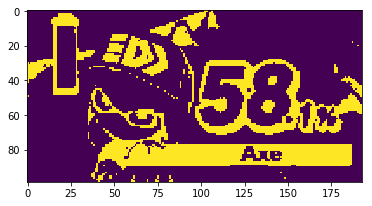

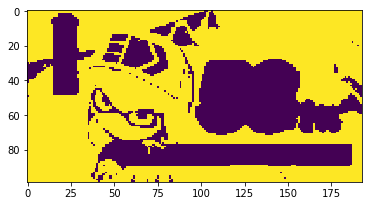

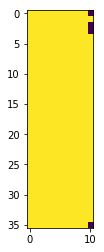

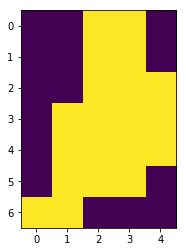

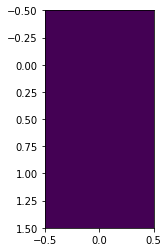

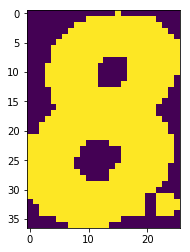

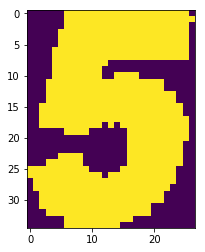

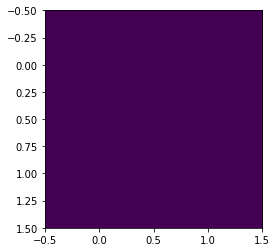

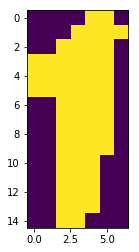

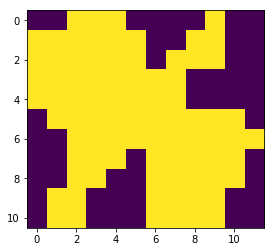

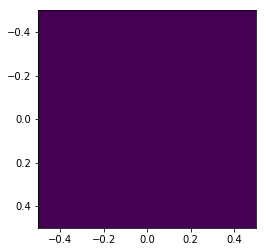

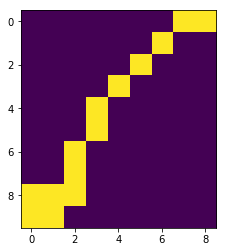

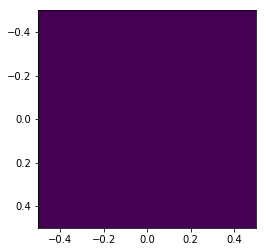

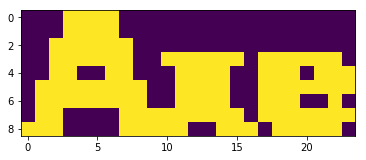

In [114]:
blobs = extract_blobs(img_inverted)

for i, blob in enumerate(blobs):
    _, ax = plt.subplots(1,1)
    ax.imshow(blob)

In [97]:
# Make an atlas from the digits that I have at this directory
digits_dir = r'E:\Ultimate\day1_streams\digits'
digits_index = [[] for _ in range(10)]
stats_array = []

for d in os.listdir(digits_dir):
    full_root = os.path.join(digits_dir, d)
    
    for f in os.listdir(full_root):
        full_path = os.path.join(full_root, f)
        
        i = int(d)
        img = cv2.imread(full_path)
        binary_image = cv2.inRange(img, (40, 40, 40), (255, 255, 255))
        digits_index[i].append(binary_image)
        
        stats_array.append(digits_index[i][-1].shape[:2])
        
for i in range(10):
    print("{} : {}".format(i, len(digits_index[i])))

0 : 50
1 : 73
2 : 47
3 : 35
4 : 58
5 : 45
6 : 51
7 : 35
8 : 45
9 : 51


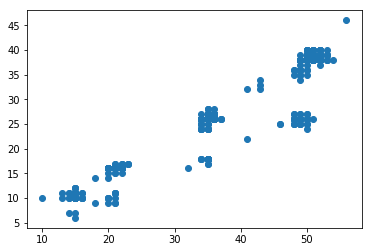

In [98]:
widths = [s[0] for s in stats_array]
heights = [s[1] for s in stats_array]
plt.scatter(widths, heights)

In [118]:
cell_dim = 32
atlas_height = np.max(np.array([len(digits_index[i]) for i in range(10)])) * cell_dim
atlas_width  = cell_dim * 10

atlas = np.zeros((atlas_height, atlas_width)).astype('uint8')

for digit in range(10):
    for i, img in enumerate(digits_index[digit]):
        xmin, ymin = digit * cell_dim, i * cell_dim
        xmax, ymax = xmin + cell_dim, ymin + cell_dim
        
        cell_img = cv2.resize(img, (cell_dim, cell_dim))
        atlas[ymin:ymax, xmin:xmax] = cell_img
        
cv2.imwrite(r'C:\users\phyto\desktop\atlas.png', atlas)

True

In [148]:
cell_dim = 32
#min_rows = np.min(np.array([len(digits_index[i]) for i in range(10)]))
min_rows = 1
print("Min rows = {}".format(min_rows))
atlas_height = min_rows * cell_dim
atlas_width  = cell_dim * 10

atlas = np.zeros((atlas_height, atlas_width)).astype('uint8')

for digit in range(10):
    np.random.shuffle(digits_index[digit])
    for i, img in enumerate(digits_index[digit][:min_rows]):
        xmin, ymin = digit * cell_dim, i * cell_dim
        xmax, ymax = xmin + cell_dim, ymin + cell_dim
        
        cell_img = cv2.resize(img, (cell_dim, cell_dim))
        atlas[ymin:ymax, xmin:xmax] = cell_img
        
cv2.imwrite(r'C:\users\phyto\desktop\atlas2.png', atlas)

Min rows = 1


True

0.11499977111816406


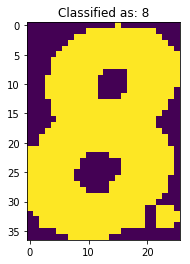

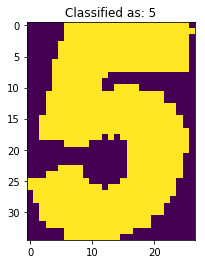

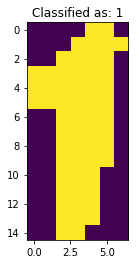

In [154]:
import time
start_time = time.time()

for blob in blobs:
    blob_cell = cv2.resize(blob, (cell_dim, cell_dim))
    response = cv2.matchTemplate(blob_cell, atlas, cv2.TM_CCORR_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(response)
    
    if max_val > 0.95:
        digit = max_loc[0] // cell_dim
        
        if max_loc[1] > len(digits_index[digit]) * cell_dim:
            continue
        
        _, ax = plt.subplots(1, 1)
        ax.set_title("Classified as: {}".format(digit))
        ax.imshow(blob)

runtime = time.time() - start_time
print(runtime) # was 0.02300286293029785 without plots

#
# TODO: Plot runtime as function of min_rows
# 